<a href="https://colab.research.google.com/github/ZanePeycke/DL/blob/master/First_Steps_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [0]:
# Randomize the data to avoid any ordering effects that could effect SGD
# Scale median house value to thousands, this will allow us to learn more efficiently
# with a common learning rate
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [0]:
california_housing_dataframe['median_house_value'] /=1000.0

In [5]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
149,-116.2,33.7,26.0,2399.0,625.0,2654.0,535.0,2.3,60.6
1942,-117.3,34.4,11.0,3572.0,592.0,1876.0,507.0,3.7,105.1
7388,-118.3,34.1,48.0,1354.0,279.0,716.0,309.0,3.7,385.0
1528,-117.2,33.0,20.0,3370.0,433.0,1020.0,408.0,11.1,500.0
15704,-122.4,37.7,52.0,1931.0,329.0,1025.0,293.0,2.9,192.0
...,...,...,...,...,...,...,...,...,...
14339,-122.1,37.4,19.0,1085.0,288.0,1009.0,305.0,3.9,276.0
10321,-120.1,37.0,41.0,1164.0,211.0,476.0,171.0,2.4,70.7
13925,-122.0,37.4,30.0,1269.0,290.0,556.0,266.0,3.8,325.0
3574,-117.9,33.9,27.0,829.0,114.0,383.0,133.0,9.3,293.5


In [6]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [0]:
# Use linear regression to predict median home value from the number of rooms

#Define an input feature (total rooms)
my_feature = california_housing_dataframe[["total_rooms"]]

In [0]:
#Make a numeric feature column for total rooms
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [0]:
#Define our label / target (median_house_value)
targets = california_housing_dataframe["median_house_value"]

In [0]:
#Configure the linear regressor
# Let's train the model using GradientDescentOptimizer
# GradientDescentOptimizer implements Mini-Batch Stochastic Gradient Descent. 
# learning_rate argument controls the size of the gradient step

# Gradient Clipping - clip_gradients_by_norm ensures the magnitude of the gradients do not
# become too large during taining (this can cause the gradient descent to fail)

my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

In [0]:
# Congifure the linear regression model with our feature columns and optimizer
# Use a learning rate of .0000001 for gradient descent
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = feature_columns,
    optimizer = my_optimizer
)

In [0]:
# Now, we need to instruct the model on how to import and preprocess our data
# We also want to specify training parameters like how to batch, shuffle, and repeat

# Convert our pandas feature data into a duct of NP arrays
# then we can use TF Dataset API to construct a dataset object and break the set 
# into batches to be repeated for the specified number of epochs

# Setting shuffle to true passes the data randomly during training
# buffer_size specifies the size of the dataset from which suffle will randomly sample


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
  """ Trains a linear regression model of one feature.
  
  Args:
    features: pandas df of features
    targets: pandas df of targets
    batch_size: Size of batches to be passed to the model
    shuffle: Whether to shuffle the data (true or false)
    num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely

  Returns:
    Tuple of (features, labels) for next data batch
  """

  #convert pandas data into a dict of np arrays.
  features = {key:np.array(value) for key,value in dict(features).items()}

  # Construct a dataset, and configure batching/repeating.
  ds = Dataset.from_tensor_slices((features, targets)) #2GB limit 
  ds = ds.batch(batch_size).repeat(num_epochs)

  # Shuffle the data (if specified)
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)

  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [0]:
# Now for model training
# Call train on our linear_regressor to train the model. 
# We wrap my_input_fn in a lambda so we can pass in my_feature and targets as
# arguments and train for 100 steps
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps = 100
)

# We use _ for values we won't need later

In [14]:
# Evaluate the model by making proedictions on that training data to see how
# well the model fit during training

# This is only training error, so we are not looking at how it generalizes now

# Create an input function for predictions
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a Numpy array, then calculate error metrics
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("MSE on training data: %0.3f" % mean_squared_error)
print("RMSE on training data: %0.3f" % root_mean_squared_error)


MSE on training data: 56367.025
RMSE on training data: 237.417


In [16]:
# What do these values mean?
# We generally like RMSE because it is more interpretable
# and can be interpreted on the same scale as the original targets
# Let's compare the RMSE to the difference of the min and max of our targets:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %.3f" % min_house_value)
print("Max. Median House Value: %.3f" % max_house_value)
print("Max Min difference: %.3f" % min_max_difference)
print("RMSE: %.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Max Min difference: 485.002
RMSE: 237.417


In [17]:
# The error spans a large range of target values
# Let's develop basic strategies to reduce model error
# How well do the predictions match our targets in terms of overall summary stats?

calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [0]:
# Let's try some visualization
# Get a uniform random sample of the data for a readable scatter
sample = california_housing_dataframe.sample(n=300)

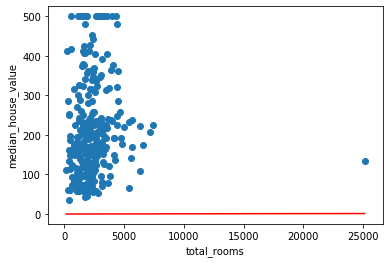

In [19]:
# Plot the line we learned, drawing from the model's bias term and feature weight
# and the scatter plot

# Get the min and max total_rooms values
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1)
plt.plot([x_0, x_1], [y_0, y_1], c='r')

plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample
plt.scatter(sample["total_rooms"], sample["median_house_value"])
plt.show()


In [0]:
# hashtag way off 
# Try changing hyperparameters
# For convenience, put everything we've done in a single function
# Allows to easily call function with different parameters to test their effect
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a lin reg model with one feature
  
  Args:
    learning_rate: `float` 
    steps: nonzero `int` total number of training steps. Each step is a forward
      and backward passing using a single batch
    batch_size: nonzero `int` 
    input_feature: `string` specifying a column from `california_housing_dataframe`
  """
  periods = 10
  steps_per_period = steps / periods
  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  #Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]

  #input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)

  #create lin reg object
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # plot the model's line each period
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1,1,periods)]

  # Train the model in a loop so we can assess periodically
  print("Training model...")
  print("RMSE on training data:")
  root_mean_squared_errors = []
  for period in range(0,periods):
    #train model, starting from prior state
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )

  # Compute predictions
  predictions = linear_regressor.predict(input_fn=prediction_input_fn)
  predictions = np.array([item['predictions'][0] for item in predictions])
  
  # Compute loss
  root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets)
  )

  # Print current loss and add loss metrics to the list
  print(" period %02d : %.2f" % (period, root_mean_squared_error))
  root_mean_squared_errors.append(root_mean_squared_error)

  # Track weights and biases over time and ensure data and line are plotted neatly
  y_extents = np.array([0, sample[my_label].max()])

  weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
  bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

  x_extents = (y_extents - bias) / weight
  x_extents = np.maximum(np.minimum(x_extents,
                                    sample[my_feature].max()),
                         sample[my_feature].min())
  y_extents = weight * x_extents + bias
  plt.plot(x_extents, y_extents, color=colors[period])
  print("Model training finished.")

  # Graph of loss metrics over periods.
  plt.subplot(1,2,2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("RMSE vs Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Table with calibration data
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE on training data : %.2f" % root_mean_squared_error)


Training model...
RMSE on training data:
 period 09 : 166.74
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,121.6,207.3
std,100.3,116.0
min,0.1,15.0
25%,67.3,119.4
50%,97.8,180.4
75%,145.0,265.0
max,1745.1,500.0


Final RMSE on training data : 166.74


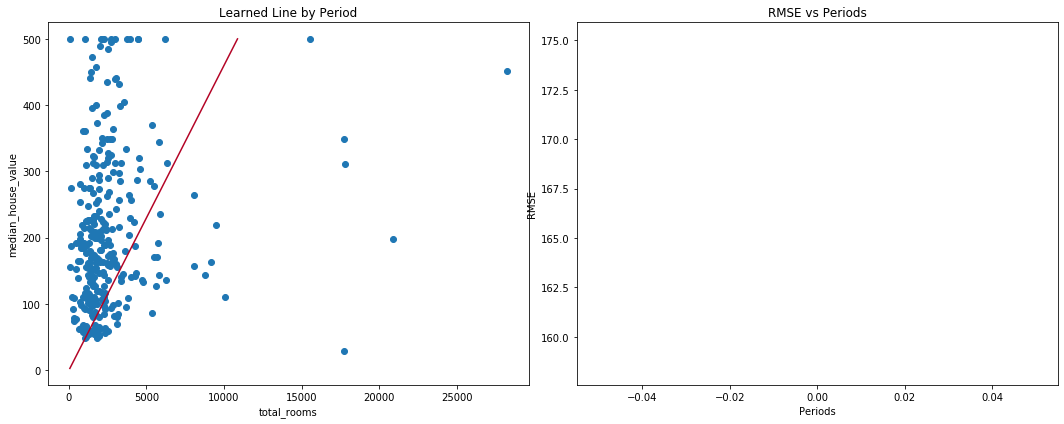

In [29]:
# Try to achieve an RMSE less than 180

# Increase learning rate by one significant fig
train_model(
    learning_rate = .0001,
    steps=100,
    batch_size=1
)

Training model...
RMSE on training data:
 period 09 : 196.42
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,211.5,207.3
std,174.4,116.0
min,0.2,15.0
25%,117.0,119.4
50%,170.2,180.4
75%,252.1,265.0
max,3034.9,500.0


Final RMSE on training data : 196.42


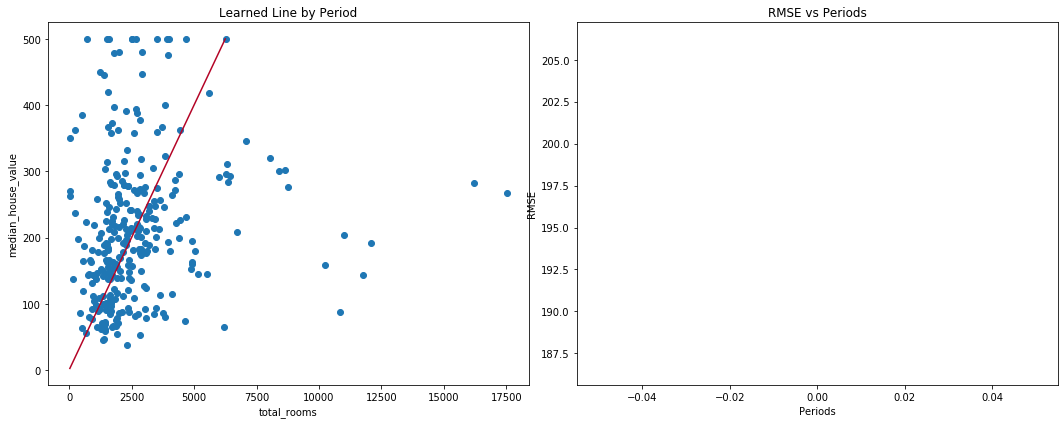

In [37]:
# RMSE below 180, let's try to go lower

train_model(
    learning_rate=.001,
    steps=400,
    batch_size=5,
)